In [47]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
import os
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

sns.set_theme(style="ticks")

In [48]:
# Use raw string or double backslashes for the path
path = r"E:\Github\White-Blood-cell-\bloodcells_dataset"

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Check if the directory exists
if not os.path.exists(path):
    print(f"Directory {path} does not exist.")
else:
    dataset, test_dataset = keras.utils.image_dataset_from_directory(
        directory=path,
        image_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        label_mode="int",
        validation_split=0.2,
        subset="both",
        shuffle=True,
        seed=42
    )

    # Get class names
    class_names = dataset.class_names
    print(class_names)

Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Using 3418 files for validation.
['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


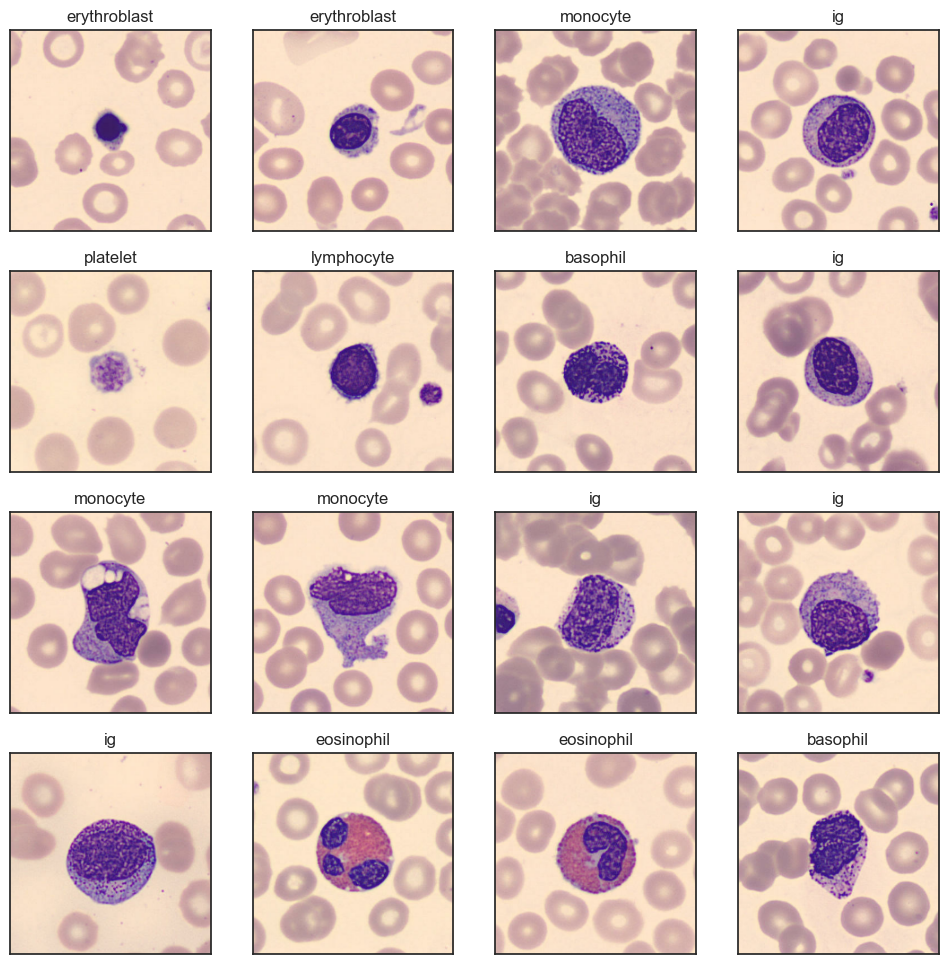

In [49]:
# Plot 16 images from the dataset as examples
fig, ax = plt.subplots(4, 4, figsize=(12,12))
ax = ax.flat
for images, labels in dataset.take(1):
  for i in range(16):
    ax[i].set_title(class_names[labels[i].numpy()])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(images[i].numpy().astype("uint8"))

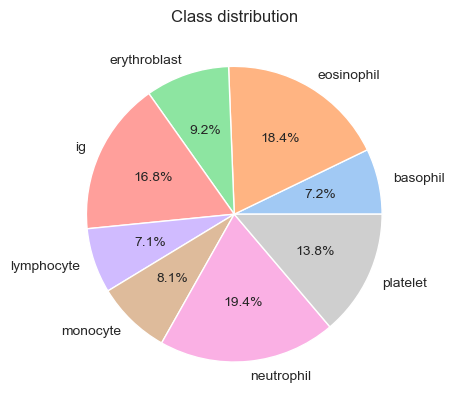

In [50]:
# Check if classes are balanced
labels = np.concatenate([label for image, label in dataset], axis=0)
unique, counts = np.unique(labels, return_counts=True)
plt.pie(x=counts, labels=class_names, autopct='%.1f%%', textprops={'size': 'smaller'},
        colors=sns.color_palette('pastel')[0:8])
plt.title("Class distribution")
plt.show()

In [51]:
# Split dataset in train and validation set
num_elements = len(dataset)
train_size = int(0.8 * num_elements)
val_dataset = dataset.skip(train_size).prefetch(tf.data.AUTOTUNE)
train_dataset = dataset.take(train_size).prefetch(tf.data.AUTOTUNE)

# Check length
len(train_dataset), len(val_dataset), len(test_dataset)

(342, 86, 107)

In [52]:
# Check format
for image_batch, labels_batch in train_dataset.take(1):
  print(f"Train data: {image_batch.shape}")
  print(f"Train labels: {labels_batch.shape}")

for image_batch, labels_batch in val_dataset.take(1):
  print(f"Validation data: {image_batch.shape}")
  print(f"Validation labels: {labels_batch.shape}")

for image_batch, labels_batch in test_dataset.take(1):
  print(f"Test data: {image_batch.shape}")
  print(f"Test labels: {labels_batch.shape}")

Train data: (32, 224, 224, 3)
Train labels: (32,)
Validation data: (32, 224, 224, 3)
Validation labels: (32,)
Test data: (32, 224, 224, 3)
Test labels: (32,)


In [53]:
# Check pixel intesities
for image, label in train_dataset.take(1):
  print(tf.reduce_max(image))
  print(tf.reduce_min(image))

tf.Tensor(255.0, shape=(), dtype=float32)
tf.Tensor(2.4986997, shape=(), dtype=float32)


## Model 1 (Baseline DNN)

Consists of a rescaling layer, a flattening layer, 5 hidden dense layer with 128 neurons and a ReLU activation function, and an output layer with 8 neurons and a softmax activation function.

In [54]:
# Create a lab-book to track the different experiments
lab_book = {}

# Create early stopping callback
early_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True,
                                         monitor="val_accuracy", min_delta=0.005)

In [55]:
# Define the lab book name entry
name = "Dense_Neural_Network"

# Set a seed for reproducibility
tf.random.set_seed(42)

# Build the model
Dense_Neural_Network = keras.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Rescaling(1./255),
    layers.Flatten(),
    layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(8, activation="softmax")
], name=name)

# Print the model summary
Dense_Neural_Network.summary()

Model: "Dense_Neural_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 128)                 │      19,267,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,334,792 (73.76 MB)

 Trainable params: 19,334,792 (73.76 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Compile the model
Dense_Neural_Network.compile(optimizer=keras.optimizers.Adam(),
                             loss=keras.losses.SparseCategoricalCrossentropy(),
                             metrics=["accuracy"])

In [57]:
# Fit the model
history_1 = Dense_Neural_Network.fit(train_dataset,
                                     validation_data=val_dataset,
                                     epochs=25,
                                     callbacks=[early_cb])

Epoch 1/25


ValueError: 'Dense Neural Network_Dense Neural Network_Deep Neural Network_Dense_Neural_Network_dense_55_kernel_momentum' is not a valid scope name. A scope name has to match the following pattern: ^[A-Za-z0-9_.\\/>-]*$

In [ ]:
# Write lab-book
train_accuracy = model_1.evaluate(train_dataset)[1]
val_accuracy = model_1.evaluate(val_dataset)[1]
lab_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy}

In [ ]:
train_accuracy

In [ ]:
val_accuracy

In [ ]:
# Evaluate model on test dataset
test_accuracy = model_1.evaluate(test_dataset)[1]

# Record the test accuracy in the lab book
lab_book[name].update({"test_accuracy": test_accuracy})

# Print the lab book entry to verify
print(lab_book[name])

## Model 2 (Simple CNN)

Consists of a rescaling layer followed by a Conv2D layer with 8 filters and a MaxPool2D layer, a flattening layer and the standard output layer.

In [ ]:
# Lab book name entry
name = "Model_2"

# Build model
tf.random.set_seed(42)
model_2 = keras.Sequential(
    [layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
     layers.Rescaling(1./255),
     layers.Conv2D(filters=8, kernel_size=(3,3),
                   padding="same", activation="relu",
                   kernel_initializer="he_normal"),
     layers.MaxPool2D(),
     layers.Flatten(),
     layers.Dense(8, activation="softmax")
     ], name=name)

model_2.summary()

In [ ]:
# Compile model
model_2.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit model
history_2 = model_2.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=25,
                        callbacks=[early_cb])

In [ ]:
# Write lab-book
train_accuracy_2 = model_2.evaluate(train_dataset)[1]
val_accuracy_2 = model_2.evaluate(val_dataset)[1]
lab_book[name] = {"train_accuracy": train_accuracy_2, "val_accuracy": val_accuracy_2}

In [ ]:
train_accuracy_2

In [ ]:
val_accuracy_2

In [ ]:
# Evaluate model on test dataset
test_accuracy_2 = model_2.evaluate(test_dataset)[1]

# Record the test accuracy in the lab book
lab_book[name].update({"test_accuracy": test_accuracy_2})

# Print the lab book entry to verify
print(lab_book[name])

**Conclusion:**

* The simple CNN model is highly overfitting. Therefore, data augmentation is implemented.

## Model 3 (CNN with data augmentation)

Same model architecture as Model 2, but this time with a built-in data augmentation layer.


In [ ]:
# Set up data augmentation layers
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.4)
    ])

In [ ]:
# Lab book name entry
name = "Model_3"

# Build model
tf.random.set_seed(42)
model_3 = keras.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Rescaling(1./255),
    data_augmentation,
    layers.Conv2D(filters=8, kernel_size=(3,3),
                  padding="same", activation="relu",
                  kernel_initializer="he_normal"),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(8, activation="softmax")
    ], name=name)

model_3.summary()

In [ ]:
# Compile model
model_3.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit model
history_3 = model_3.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=25,
                        callbacks=[early_cb])

In [ ]:
# Write lab-book
train_accuracy_3 = model_3.evaluate(train_dataset)[1]
val_accuracy_3 = model_3.evaluate(val_dataset)[1]
lab_book[name] = {"train_accuracy": train_accuracy_3, "val_accuracy": val_accuracy_3}

In [ ]:
train_accuracy_3

In [ ]:
val_accuracy_3

In [ ]:
# Evaluate model on test dataset
test_accuracy_3 = model_3.evaluate(test_dataset)[1]

# Record the test accuracy in the lab book
lab_book[name].update({"test_accuracy": test_accuracy_3})

# Print the lab book entry to verify
print(lab_book[name])

**Conclusion:**

* Data augmentation effectively prevented overfitting, allowing a more complex CNN architecture to be built.

## Model 4 (More complex CNN with data augmentation)

First, the images are rescaled and augmented. Then there are 3 Conv blocks between the preprocessing layers and the output layer. Each Conv block consists of a Conv2D layer followed by a MaxPool2D layer. The filter size increases from 8 to 16 to 32 filters, the activation function is ReLU, and the kernel size is (3,3) except for the first Conv block (5,5).

In [ ]:
# Lab book name entry
name = "Model_4"

# Build model
tf.random.set_seed(42)
model_4 = keras.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Rescaling(1./255),
    data_augmentation,
    layers.Conv2D(filters=8, kernel_size=(5,5),
                  padding="same", activation="relu",
                  kernel_initializer="he_normal"),
    layers.MaxPool2D(),
    layers.Conv2D(filters=16, kernel_size=(3,3),
                  padding="same", activation="relu",
                  kernel_initializer="he_normal"),
    layers.MaxPool2D(),
    layers.Conv2D(filters=32, kernel_size=(3,3),
                  padding="same", activation="relu",
                  kernel_initializer="he_normal"),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(8, activation="softmax")
    ], name=name)

model_4.summary()

In [ ]:
# Compile model
model_4.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit model
history_4 = model_4.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=25,
                        callbacks=[early_cb])

In [ ]:
# Write lab-book
train_accuracy_4 = model_4.evaluate(train_dataset)[1]
val_accuracy_4 = model_4.evaluate(val_dataset)[1]
lab_book[name] = {"train_accuracy": train_accuracy_4, "val_accuracy": val_accuracy_4}

In [ ]:
train_accuracy_4

In [ ]:
val_accuracy_4

In [ ]:
# Evaluate model on test dataset
test_accuracy_4 = model_4.evaluate(test_dataset)[1]

# Record the test accuracy in the lab book
lab_book[name].update({"test_accuracy": test_accuracy_4})

# Print the lab book entry to verify
print(lab_book[name])

**Conclusion:**

* Accuracy increased by about 5% with the more complex CNN model without significant overfitting.
* Since some of the images vary greatly in their low-level features (e.g., reddish granules in eosinophils), the ResNet50 architecture is used because of its ability to capture low-level feature variations more effectively.

## Model 5 (Feature extraction with ResNet50)

The ResNet50 model is used to extract features. To do this, the datasets must be transformed to meet the requirements of this model.

In [ ]:
# Prepare data for ResNet50 input
train_dataset_resnet = train_dataset.map(lambda X, y: (preprocess_input(X), y)).prefetch(tf.data.AUTOTUNE)
val_dataset_resnet = val_dataset.map(lambda X, y: (preprocess_input(X), y)).prefetch(tf.data.AUTOTUNE)
test_dataset_resnet = test_dataset.map(lambda X, y: (preprocess_input(X), y)).prefetch(tf.data.AUTOTUNE)

# Check format
for image_batch, labels_batch in train_dataset_resnet.take(1):
  print(f"Train data: {image_batch.shape}")
  print(f"Train labels: {labels_batch.shape}")

for image_batch, labels_batch in val_dataset_resnet.take(1):
  print(f"Validation data: {image_batch.shape}")
  print(f"Validation labels: {labels_batch.shape}")

for image_batch, labels_batch in test_dataset_resnet.take(1):
  print(f"Test data: {image_batch.shape}")
  print(f"Test labels: {labels_batch.shape}")

In [ ]:
# Check pixel intesities
for image, label in train_dataset_resnet.take(1):
  print(tf.reduce_max(image))
  print(tf.reduce_min(image))

In [ ]:
# Name the model
name = "Model_5"

# Download the pretrained resnet model and save it as a layer
feature_extraction_layer = ResNet50(include_top=False,
                                    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze all layers of base model
feature_extraction_layer.trainable = False

# Build model
tf.random.set_seed(42)
model_5 = keras.Sequential([data_augmentation,
                            feature_extraction_layer,
                            layers.GlobalAvgPool2D(),
                            layers.Dense(8, activation="softmax")
                            ], name=name)

In [ ]:
# Compile model
model_5.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit model
history_5 = model_5.fit(train_dataset_resnet,
                        validation_data=val_dataset_resnet,
                        epochs=25,
                        callbacks=[early_cb])

In [ ]:
# Write lab-book
train_accuracy_5 = model_5.evaluate(train_dataset_resnet)[1]
val_accuracy_5 = model_5.evaluate(val_dataset_resnet)[1]
lab_book[name] = {"train_accuracy": train_accuracy_5, "val_accuracy": val_accuracy_5}

In [ ]:
train_accuracy_5

In [ ]:
val_accuracy_5

In [ ]:
# Check test set accuracy of model 5 since base model will be changed afterwards
test_scores = {}
test_accuracy = model_5.evaluate(test_dataset_resnet)[1]
test_scores["Model_5"] = test_accuracy

**Conclusion**:

* Performs similarly to Model 4. Probably fine-tuning could improve its performance.

## Model 6 (Transfer learning with ResNet50)

The same architecture as in Model 5, but this time the ResNet50 base model is completely unfrozen and the entire model is trained.

In [ ]:
# Name the model
name = "Model_6"

# Unfreeze all layers of base model
feature_extraction_layer.trainable = True

# Build model
tf.random.set_seed(42)
model_6 = keras.Sequential([data_augmentation,
                            feature_extraction_layer,
                            layers.GlobalAvgPool2D(),
                            layers.Dense(8, activation="softmax")
                            ], name=name)

In [ ]:
# Compile model
model_6.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
                metrics=["accuracy"])

In [ ]:
# Fit model
history_6 = model_6.fit(train_dataset_resnet,
                        validation_data=val_dataset_resnet,
                        epochs=25,
                        callbacks=[early_cb])

In [ ]:
# Write lab-book
train_accuracy_6 = model_6.evaluate(train_dataset_resnet)[1]
val_accuracy_6 = model_6.evaluate(val_dataset_resnet)[1]
lab_book[name] = {"train_accuracy": train_accuracy_6, "val_accuracy": val_accuracy_6}

In [ ]:
train_accuracy_6

In [ ]:
val_accuracy_6

In [ ]:
# Evaluate model on test dataset
test_accuracy_6 = model_6.evaluate(test_dataset)[1]

# Record the test accuracy in the lab book
lab_book[name].update({"test_accuracy": test_accuracy_6})

# Print the lab book entry to verify
print(lab_book[name])

VGG 16 model

**Conclusion**:

* Incredible performance of approximately 98.6% accuracy on the validation set.

## Test all models on the test set

In [ ]:
# Test models on respective test sets
model_list = [model_1, model_2, model_3, model_4, model_5, model_6]
for counter, model in enumerate(model_list):
  if model != model_6:
    score = model.evaluate(test_dataset, verbose=0)[1]
    print(f"Model {counter+1}: {score:.2f}")
    test_scores["Model_"+str(counter+1)] = score
  else:
    score = model.evaluate(test_dataset_resnet, verbose=0)[1]
    print(f"Model 6: {score:.2f}")
    test_scores["Model_6"] = score

**Conclusion:**

- The test set represents the overall data very well, as evidenced by the very small differences in accuracy between the validation and test sets.
- Model 6 performs best with a test set accuracy of 99%.

## Examine the errors of Model 6 on the test data


In [ ]:
# Storage lists for predictions, probabilities and true labels
y_pred = []
y_pred_proba = []
y_true = []


# Iterate over the dataset
for image_batch, label_batch in test_dataset_resnet:
   y_true.append(label_batch)
   preds = model_6.predict(image_batch, verbose=0)
   y_pred_proba.append(preds)
   y_pred.append(np.argmax(preds, axis=-1))

# Concatenate and convert correct and predicted labels
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = tf.cast(correct_labels, "int64")
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
# Check confusion matrix of model 6
fig, axes = plt.subplots(figsize=(10,6))
ConfusionMatrixDisplay.from_predictions(y_true=correct_labels,
                                        y_pred=predicted_labels,
                                        display_labels=class_names,
                                        normalize="true",
                                        cmap="Blues",
                                        values_format=".1%",
                                        colorbar=False,
                                        ax=axes)
axes.set_xticklabels(labels=class_names, rotation=45,
                     ha='right',
                     rotation_mode='anchor')
plt.show()

**Conclusion:**

- The various class accuracies range from 96.3% (ig) to 100.0% (erythroblast).

**Take a look at the most common mistakes.**

In [ ]:
# Plot confusion matrix with zero weigth in the correct predictions
sample_weight = (correct_labels != predicted_labels)
fig, axes = plt.subplots(figsize=(10,6))
ConfusionMatrixDisplay.from_predictions(y_true=correct_labels,
                                        y_pred=predicted_labels,
                                        display_labels=class_names,
                                        cmap="Blues",
                                        sample_weight=sample_weight,
                                        ax=axes,
                                        colorbar=False)
axes.set_xticklabels(labels=class_names, rotation=45, ha='right', rotation_mode='anchor')
plt.show()

The **3 most common mistakes** are:
* Mistaking ig for beeing neutrophil (16)
* Mistaking monocyte for beeing ig (7)
* Mistaken neutrophile for beeing ig (7)

In [ ]:
# Print classification report
print(
    "Classification report rebuilt from confusion matrix:\n"
    f"{classification_report(y_true=correct_labels, y_pred=predicted_labels, target_names=class_names)}\n"
)

**Conclusion:**
- $F_1$ scores range from 0.99 for most classes to 0.97 (ig).

**Collect 40 wrongly predicted images to investigate the reasons.**

In [ ]:
# Check predictions and store them in arrays
y_true = []
y_pred = []
images = []
for image, label in test_dataset.unbatch():
  # Reshape for model compatibility
  image_reshaped = tf.reshape(image, shape=(1,224,224,3))
  # Preprocess for resnet
  image_processed = preprocess_input(image_reshaped)
  # Predict most likely class
  prediction = model_6.predict(image_processed, verbose=0)
  prediction = np.argmax(prediction, axis=-1)
  # Check if prediction and true label are not equal
  if prediction != label:
    images.append(image / 255.)
    y_pred.append(prediction)
    y_true.append(label)

In [ ]:
# # Plot 60 wrongly predicted images
# fig, axes = plt.subplots(4, 10, figsize=(30,15), layout="constrained")
# for counter, axis in enumerate(axes.flatten()):
#   axis.imshow(images[counter])
#   axis.set_title(f"True label: {class_names[y_true[counter].numpy()]} \n Predicted label: {class_names[y_pred[counter].item()]}")
#   axis.set_xticks([])
#   axis.set_yticks([])
# plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Ensure you have enough images to plot
num_images = min(len(images), 40)

# Create the subplots
fig, axes = plt.subplots(4, 10, figsize=(30, 15), layout="constrained")

# Flatten the axes array for easy iteration
axes = axes.flatten()

for counter in range(num_images):
    axis = axes[counter]
    axis.imshow(images[counter])
    axis.set_title(f"True label: {class_names[y_true[counter].numpy()]} \n Predicted label: {class_names[y_pred[counter].item()]}")
    axis.set_xticks([])
    axis.set_yticks([])

# Hide any remaining empty subplots
for counter in range(num_images, len(axes)):
    axes[counter].axis('off')

plt.show()


## Performance trajectory

In [ ]:
# Compare accuracies of different models
accuracies_df = pd.DataFrame(lab_book).transpose()
accuracies_df["test_accuracy"] = test_scores
accuracies_df

In [ ]:
# Plot accuracies against models
sns.lineplot(data=accuracies_df, markers=True)
plt.grid()
plt.xlabel("Model Name")
plt.ylabel("Accuracy")
plt.show()